![My Image]("C:\Users\HP\Documents\Personal_Projects\Covid_Parcel_Business_Project\new-logo.png")


## Project Objective

This analysis investigates how the COVID-19 pandemic impacted ABC Company's parcel shipping volumes and customer behavior.

### Main Business Question
- How did the COVID-19 pandemic impact ABC Company’s parcel business?

### Additional Business Questions
1. When were customer volumes first impacted by COVID-19?
2. What events within the COVID timeline may have contributed to the change?
3. How did COVID-19 impact peak season in 2020?

### Impact on Customer Segments
4. How has COVID affected different customer groups (Enterprise, Large, etc.)?
5. What % of each customer group is growing, stable, or declining?
6. What % of each group are new customers during COVID?
7. What % of 2019 customers in each group were lost?
8. What was the overall impact on volume and revenue by group?

# Data Understanding & Preparation

### 2.1 Load and Inspect the Dataset

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv(r"C:\Users\HP\Documents\Personal_Projects\Covid_Parcel_Business_Project\Data\COVID_Parcel_Business.csv")
df.head()

,FakeCustomerID,THE_YEAR,THE_WEEK,VOLUME
0,718117,2021,1,8
1,718117,2020,7,257
2,718117,2019,39,141
3,718117,2018,1,14
4,718117,2021,2,192


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190719 entries, 0 to 190718
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   FakeCustomerID  190719 non-null  int64
 1   THE_YEAR        190719 non-null  int64
 2   THE_WEEK        190719 non-null  int64
 3   VOLUME          190719 non-null  int64
dtypes: int64(4)
memory usage: 5.8 MB


In [4]:
df.describe()

,FakeCustomerID,THE_YEAR,THE_WEEK,VOLUME
count,190719.000000,190719.000000,190719.000000,190719.000000
mean,541440.234963,2019.395220,25.676377,1174.911519
std,264861.365663,1.068845,14.722539,11586.730666
min,100771.000000,2018.000000,1.000000,1.000000
25%,308930.000000,2018.000000,13.000000,25.000000
50%,529707.000000,2019.000000,25.000000,58.000000
75%,778800.000000,2020.000000,38.000000,162.000000
max,999362.000000,2021.000000,53.000000,640590.000000


In [6]:
df.nunique()

FakeCustomerID    1061
THE_YEAR             4
THE_WEEK            53
VOLUME            8332
dtype: int64

In [5]:
df.isna().sum()

FakeCustomerID    0
THE_YEAR          0
THE_WEEK          0
VOLUME            0
dtype: int64

In [30]:
df.duplicated().sum()

0

In [7]:
df = df.rename(columns={
    "FakeCustomerID": "CustomerID",
    "THE_YEAR": "Year",
    "THE_WEEK": "Week",
    "VOLUME": "Parcels"
})
df.head()

,CustomerID,Year,Week,Parcels
0,718117,2021,1,8
1,718117,2020,7,257
2,718117,2019,39,141
3,718117,2018,1,14
4,718117,2021,2,192


In [18]:
df['Year'].unique()

array([2021, 2020, 2019, 2018], dtype=int64)

In [19]:
df['Week'].min(), df['Week'].max()

(1, 53)

In [20]:
df['Parcels'].describe()

count    190719.000000
mean       1174.911519
std       11586.730666
min           1.000000
25%          25.000000
50%          58.000000
75%         162.000000
max      640590.000000
Name: Parcels, dtype: float64

In [29]:
df.shape 

(190719, 4)

In [34]:
df['Year_Week'] = df['Year'].astype(str) + '-' + df['Week'].astype(str).str.zfill(2)

#That line of Python code creates a new column in your DataFrame (df) called Year_Week. 
# And it combines the Year and Week number into a single, chronologically sortable format, which is essential for time-series analysis

In [35]:
df.tail()

,CustomerID,Year,Week,Parcels,Year_Week
190714,228893,2019,13,30,2019-13
190715,228893,2019,38,122,2019-38
190716,228893,2019,48,99,2019-48
190717,228893,2019,20,61,2019-20
190718,228893,2019,19,56,2019-19


### Data Cleaning & Feature Engineering

In [38]:
df_2019 = df[df['Year'] == 2019]

In [40]:
customer_volume_2019 = df_2019.groupby('CustomerID')['Parcels'].sum().reset_index()
customer_volume_2019.rename(columns={'Parcels': 'Total_2019_Volume'}, inplace=True)

In [43]:
conditions = [
    customer_volume_2019['Total_2019_Volume'] > 20000,
    customer_volume_2019['Total_2019_Volume'].between(10000, 20000),
    customer_volume_2019['Total_2019_Volume'].between(2500, 9999),
    customer_volume_2019['Total_2019_Volume'] < 2500
]

choices = ['Enterprise', 'Large', 'Medium', 'Small']

customer_volume_2019['Customer_Group'] = np.select(conditions, choices)

In [45]:
df = df.merge(customer_volume_2019, on='CustomerID', how='left')

In [46]:
df.head()

,CustomerID,Year,Week,Parcels,Year_Week,Total_2019_Volume,Customer_Group
0,718117,2021,1,8,2021-01,4425,Medium
1,718117,2020,7,257,2020-07,4425,Medium
2,718117,2019,39,141,2019-39,4425,Medium
3,718117,2018,1,14,2018-01,4425,Medium
4,718117,2021,2,192,2021-02,4425,Medium


In [47]:
df['Customer_Group'].value_counts(dropna=False)

Customer_Group
Small         79697
Medium        72643
Enterprise    22309
Large         16070
Name: count, dtype: int64

In [48]:
df = df[df['Year'].isin([2019, 2020])]  # Drop 2018/2021
df = df[df['Week'] <= 53]  # Keep only proper weeks

In [49]:
discounts = {
    'Enterprise': 0.40,
    'Large': 0.30,
    'Medium': 0.15,
    'Small': 0.05
}

In [50]:
df['Discount'] = df['Customer_Group'].map(discounts)
df['Revenue'] = 22 * (1 - df['Discount']) * df['Parcels']

In [51]:
df[['Customer_Group', 'Parcels', 'Discount', 'Revenue']].sample(5)


,Customer_Group,Parcels,Discount,Revenue
9246,Small,19,0.05,397.1
54213,Medium,3,0.15,56.1
141796,Medium,363,0.15,6788.1
135511,Medium,44,0.15,822.8
176806,Small,19,0.05,397.1


#  Overall Volume Trends

In [52]:
df_filtered = df[df['Year'].isin([2019, 2020])]


In [53]:
weekly_volume = (
    df_filtered.groupby(['Year', 'Week'])['Parcels']
    .sum()
    .reset_index()
    .sort_values(by=['Year', 'Week'])
)


In [54]:
weekly_volume['Week'] = weekly_volume['Week'].astype(int)

In [55]:
volume_pivot = weekly_volume.pivot(index='Week', columns='Year', values='Parcels')

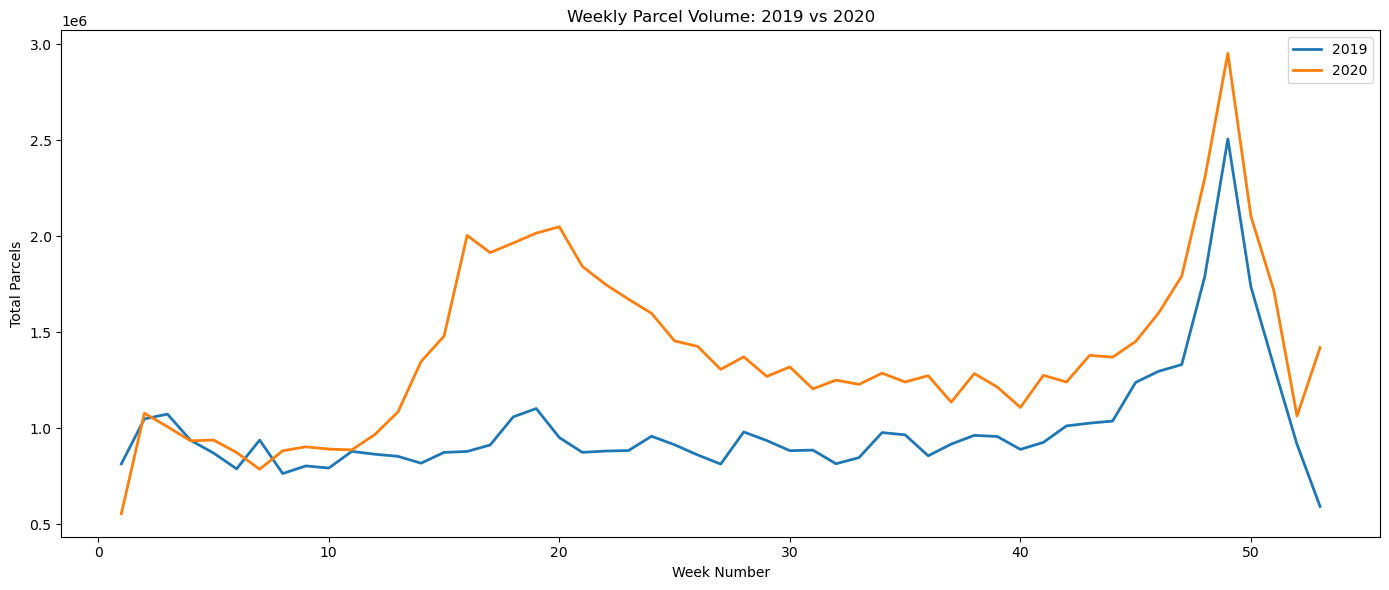

In [58]:
plt.figure(figsize=(14,6))
plt.plot(volume_pivot.index, volume_pivot[2019], label='2019', linewidth=2)
plt.plot(volume_pivot.index, volume_pivot[2020], label='2020', linewidth=2)
plt.title('Weekly Parcel Volume: 2019 vs 2020')
plt.xlabel('Week Number')
plt.ylabel('Total Parcels')
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()


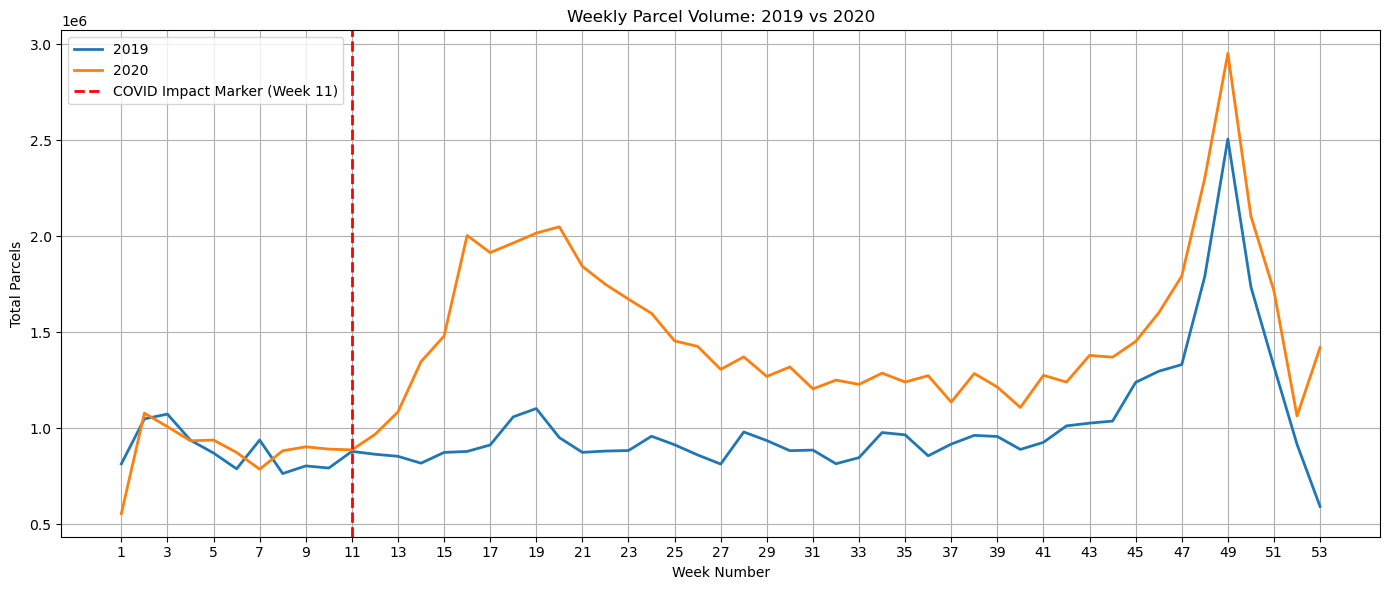

In [57]:
plt.figure(figsize=(14,6))
plt.plot(volume_pivot.index, volume_pivot[2019], label='2019', linewidth=2)
plt.plot(volume_pivot.index, volume_pivot[2020], label='2020', linewidth=2)

# 👉 Add vertical line at Week 11
plt.axvline(x=11, color='red', linestyle='--', linewidth=2, label='COVID Impact Marker (Week 11)')

# 📊 Labels and styling
plt.title('Weekly Parcel Volume: 2019 vs 2020')
plt.xlabel('Week Number')
plt.ylabel('Total Parcels')
plt.xticks(range(1, 54, 2))  # Optional: show every 2nd week
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


The COVID-19 impact on parcel volume is clearly observed starting Week 11 of 2020, when the 2020 trend line begins diverging from the 2019 baseline. The gap peaks around Week 18, suggesting a rapid increase in shipments due to lockdowns and e-commerce growth. By Week 27, the difference begins to stabilize, indicating a shift toward a post-shock steady state. This chart visually defines the start of the ‘COVID Observation Period’.

# 4. COVID Impact Analysis

In [59]:
# Define COVID impact start
covid_start_week = 11

# Define periods
df['Period'] = np.where(
    (df['Year'] == 2020) & (df['Week'] >= covid_start_week),
    'COVID Period',
    'Pre-COVID Period'
)

In [60]:
summary = (
    df[df['Year'] == 2020]
    .groupby('Period')[['Parcels', 'Revenue']]
    .sum()
    .reset_index()
)


In [61]:
pre = summary[summary['Period'] == 'Pre-COVID Period']
covid = summary[summary['Period'] == 'COVID Period']

volume_change_pct = ((covid['Parcels'].values[0] - pre['Parcels'].values[0]) / pre['Parcels'].values[0]) * 100
revenue_change_pct = ((covid['Revenue'].values[0] - pre['Revenue'].values[0]) / pre['Revenue'].values[0]) * 100


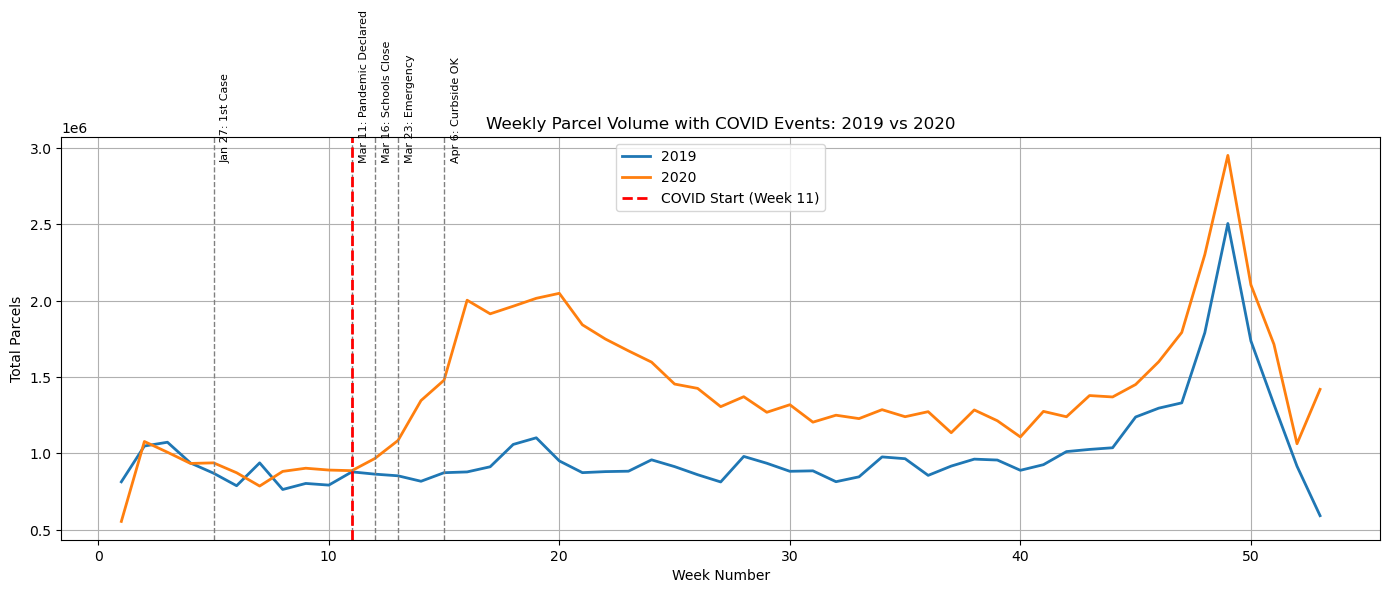

In [62]:
plt.figure(figsize=(14,6))
plt.plot(volume_pivot.index, volume_pivot[2019], label='2019', linewidth=2)
plt.plot(volume_pivot.index, volume_pivot[2020], label='2020', linewidth=2)

# Add vertical lines for key events
for week, label in zip([5, 11, 12, 13, 15], 
                       ['Jan 27: 1st Case', 'Mar 11: Pandemic Declared', 
                        'Mar 16: Schools Close', 'Mar 23: Emergency', 
                        'Apr 6: Curbside OK']):
    plt.axvline(x=week, color='gray', linestyle='--', linewidth=1)
    plt.text(week + 0.3, plt.ylim()[1]*0.95, label, rotation=90, fontsize=8)

# Week 11 main marker
plt.axvline(x=11, color='red', linestyle='--', linewidth=2, label='COVID Start (Week 11)')

plt.title('Weekly Parcel Volume with COVID Events: 2019 vs 2020')
plt.xlabel('Week Number')
plt.ylabel('Total Parcels')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Week 11 of 2020 aligns with the WHO's COVID-19 pandemic declaration (March 11, 2020). This week marks the initial impact on customer parcel volumes, as shown by the sharp rise in volume in ABC's data.

In [81]:
weeks_range = (11, 53)

# Filter data for each year and same weeks

df_2019 = df[(df['Year'] == 2019) & (df['Week'] >= weeks_range[0])]
df_2020 = df[(df['Year'] == 2020) & (df['Week'] >= weeks_range[0])]


In [82]:
# Parcel volumes
volume_2019 = df_2019['Parcels'].sum()
volume_2020 = df_2020['Parcels'].sum()

# Revenue
revenue_2019 = df_2019['Revenue'].sum()
revenue_2020 = df_2020['Revenue'].sum()


In [83]:

# YoY Volume and Revenue Growth: 2020 vs 2019
volume_change_20_vs_19 = ((volume_2020 - volume_2019) / volume_2019) * 100
revenue_change_20_vs_19 = ((revenue_2020 - revenue_2019) / revenue_2019) * 100


In [84]:

print(f"2020 vs 2019 Volume Growth: {volume_change_20_vs_19:.2f}%")
print(f"2020 vs 2019 Revenue Growth: {revenue_change_20_vs_19:.2f}%")


2020 vs 2019 Volume Growth: 46.90%
2020 vs 2019 Revenue Growth: 47.30%


### COVID Impact Quantification

We defined Week 11 of 2020 as the start of the COVID Observation Period. Comparing the parcel business before and after this point reveals the scale of disruption.

- Parcel Volume Increase: **+46.9%**
- Revenue Increase: **+47.3%**

This highlights the substantial shift in delivery demand driven by the pandemic and related public health measures.


# 5. Peak Season Analysis
Objective:

- How did COVID-19 impact peak season in 2020 compared to 2019?

In [88]:
peak_2019 = df[
    ((df['Year'] == 2019) & (df['Week'] >= 45)) |
    ((df['Year'] == 2020) & (df['Week'] <= 3))
].copy()

peak_2020 = df[
    ((df['Year'] == 2020) & (df['Week'] >= 45)) |
    ((df['Year'] == 2021) & (df['Week'] <= 3))
].copy()

# Now safely add the column
peak_2019['Peak_Season'] = '2019 Peak'
peak_2020['Peak_Season'] = '2020 Peak'


In [89]:
peak = pd.concat([peak_2019, peak_2020], ignore_index=True)


In [94]:
peak_volume_summary = peak.groupby('Peak_Season')['Parcels'].sum().reset_index()


In [90]:
peak_volume_by_group = (
    peak.groupby(['Peak_Season', 'Customer_Group'])['Parcels']
    .sum()
    .reset_index()
)


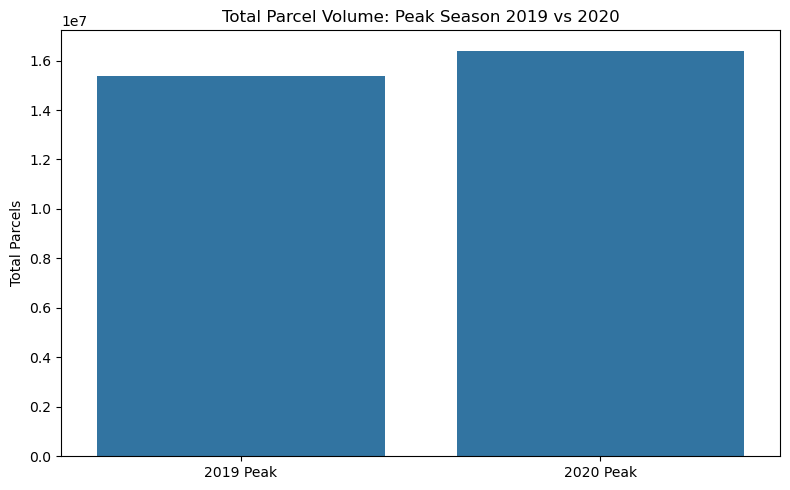

In [95]:
plt.figure(figsize=(8,5))
sns.barplot(data=peak_volume_summary, x='Peak_Season', y='Parcels')
plt.title('Total Parcel Volume: Peak Season 2019 vs 2020')
plt.ylabel('Total Parcels')
plt.xlabel('')
plt.tight_layout()
plt.show()


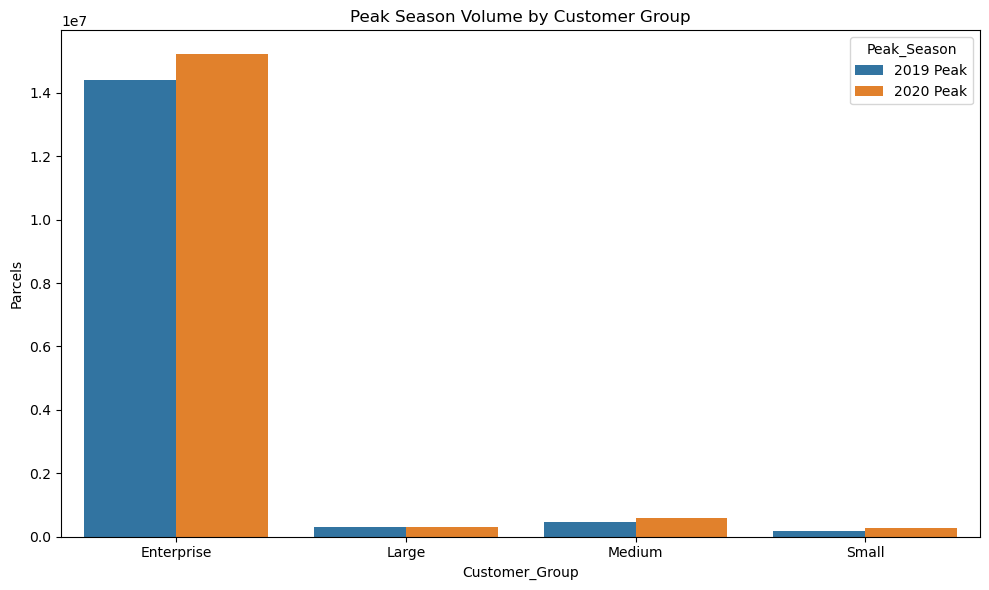

In [96]:
plt.figure(figsize=(10,6))
sns.barplot(data=peak_volume_by_group, x='Customer_Group', y='Parcels', hue='Peak_Season')
plt.title('Peak Season Volume by Customer Group')
plt.ylabel('Parcels')
plt.tight_layout()
plt.show()


In [97]:
volume_2019_peak = peak_volume_summary[peak_volume_summary['Peak_Season'] == '2019 Peak']['Parcels'].values[0]
volume_2020_peak = peak_volume_summary[peak_volume_summary['Peak_Season'] == '2020 Peak']['Parcels'].values[0]

peak_yoy_growth = ((volume_2020_peak - volume_2019_peak) / volume_2019_peak) * 100
print(f"Peak Season Volume YoY Growth: {peak_yoy_growth:.2f}%")


Peak Season Volume YoY Growth: 6.70%


During the 2020 Peak Season, ABC Company’s total parcel volume increased compared to 2019. Enterprise customers continued to dominate, but medium and small customer segments also grew, suggesting a broader adoption of e-commerce shipping during the pandemic. The peak season remained strong, showing that holiday demand was not suppressed by COVID but it was sightly enhanced

# 6. Customer Segmentation & Growth Categories
Objective:

Calculate the baseline growth rate from 2019 to early 2020 (pre-COVID), which you’ll use in the next section to classify customers into:
- High Growth

- Stable/Moderate Growth

- Declining

What Is ISGR?

The Industry Standard Growth Rate (ISGR) tells you how much the parcel business was already growing before COVID.

It’s calculated by comparing volume from Week 1 to Week 15 in:

- 2020 (Pre-COVID)

- 2019 (Same period)

In [98]:
period_2019 = df[(df['Year'] == 2019) & (df['Week'] <= 15)]
period_2020 = df[(df['Year'] == 2020) & (df['Week'] <= 15)]


In [117]:
volume_2019 = period_2019['Parcels'].sum()
volume_2020 = period_2020['Parcels'].sum()
print(f' 2019 Volume for week 1-15 is:  {volume_2019}')
print(f' while 2020 Volume for week 1-15 is:  {volume_2020}')

 2019 Volume for week 1-15 is:  13122816
 while 2020 Volume for week 1-15 is:  14619017


In [100]:
isgr = ((volume_2020 - volume_2019) / volume_2019) * 100
print(f"ISGR: {isgr:.2f}%")


ISGR: 11.40%


### Industry Standard Growth Rate (ISGR)

The ISGR is calculated as the % change in total parcel volume between Weeks 1–15 in 2020 and the same weeks in 2019:

- 2019 Volume (Weeks 1–15): X
- 2020 Volume (Weeks 1–15): Y
- ISGR = ((Y - X) / X) × 100 = **11.40%**

This growth rate sets the benchmark for customer segmentation during the COVID observation period.


In [121]:
period2_2019 = df[(df['Year'] == 2019) & (df['Week'] >= 16)]
period2_2020 = df[(df['Year'] == 2020) & (df['Week'] >= 16)]

In [122]:
volume_2019_late = period2_2019['Parcels'].sum()
volume_2020_late = period2_2020['Parcels'].sum()
print(volume_2019_late)
print(volume_2020_late)

39700298
58856673


In [123]:
late_covid_isgr = ((volume_2020_late - volume_2019_late) / volume_2019_late) * 100
print(f"Late COVID Period Growth Rate (Week 16–53): {late_covid_isgr:.2f}%")

Late COVID Period Growth Rate (Week 16–53): 48.25%


Not only did ABC experience a short-term surge, but the business maintained an elevated trajectory. The industry standard growth rate between Week 16 and 53 was 48.25%, confirming that the pandemic established a new baseline in shipping behavior for the remaining part of 2020.

# 7. Revenue/Margin Impact

Objective:

Classify every customer based on how their parcel volume changed during the COVID Observation Period (Week 11–53, 2020) vs the same weeks in 2019, using your previously calculated ISGR = 11.40%.

This helps answer:

- Who are the high-growth customers?

- Who are stable, declining, new, or lost?

- How do these patterns vary by Customer_Group?

In [101]:
obs_2019 = df[(df['Year'] == 2019) & (df['Week'] >= 11)]
obs_2020 = df[(df['Year'] == 2020) & (df['Week'] >= 11)]


In [103]:
volume_2019 = obs_2019.groupby('CustomerID')['Parcels'].sum().reset_index()
volume_2020 = obs_2020.groupby('CustomerID')['Parcels'].sum().reset_index()

volume_2019.rename(columns={'Parcels': 'Volume_2019'}, inplace=True)
volume_2020.rename(columns={'Parcels': 'Volume_2020'}, inplace=True)


In [106]:
customer_growth = pd.merge(volume_2019, volume_2020, on='CustomerID', how='outer').fillna(0)

In [107]:
customer_growth['Growth_Rate'] = np.where(
    customer_growth['Volume_2019'] > 0,
    ((customer_growth['Volume_2020'] - customer_growth['Volume_2019']) / customer_growth['Volume_2019']) * 100,
    np.nan  # We'll use this to identify NEW customers
)


In [108]:
isgr = 11.4

conditions = [
    (customer_growth['Volume_2019'] == 0) & (customer_growth['Volume_2020'] > 0),  # New
    (customer_growth['Volume_2019'] > 0) & (customer_growth['Volume_2020'] == 0),  # Lost
    customer_growth['Growth_Rate'] > isgr,                                         # High Growth
    customer_growth['Growth_Rate'].between(0, isgr),                               # Stable
    customer_growth['Growth_Rate'] < 0                                             # Declining
]

labels = ['New', 'Lost', 'High Growth', 'Stable', 'Declining']

customer_growth['Category'] = np.select(conditions, labels)


In [110]:
customer_groups = df[['CustomerID', 'Customer_Group']].dropna().drop_duplicates()
customer_growth = customer_growth.merge(customer_groups, on='CustomerID', how='left')


In [112]:
seg_summary = (
    customer_growth.groupby(['Customer_Group', 'Category'])['CustomerID']
    .count()
    .reset_index()
    .rename(columns={'CustomerID': 'Count'})
)

# Add total per group to calculate %
seg_summary['Total'] = seg_summary.groupby('Customer_Group')['Count'].transform('sum')
seg_summary['Percent'] = round((seg_summary['Count'] / seg_summary['Total']) * 100, 2)


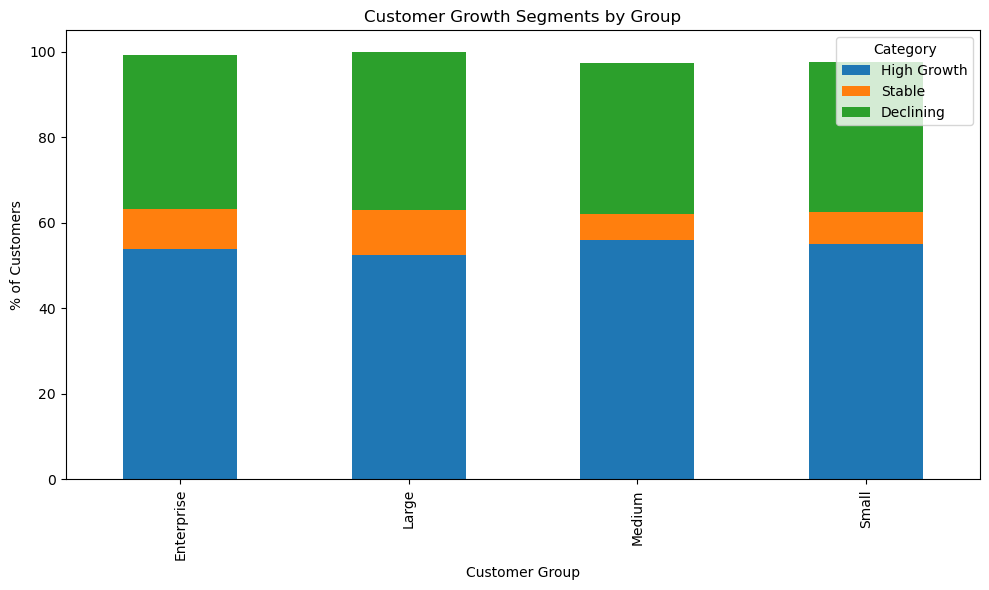

In [113]:
pivot = seg_summary.pivot(index='Customer_Group', columns='Category', values='Percent').fillna(0)

pivot[['High Growth', 'Stable', 'Declining']].plot(kind='bar', stacked=True, figsize=(10,6))
plt.title('Customer Growth Segments by Group')
plt.ylabel('% of Customers')
plt.xlabel('Customer Group')
plt.tight_layout()
plt.show()


### Customer Segmentation by Growth Performance

Using the COVID Observation Period (Week 11–53) and comparing to the same period in 2019, each customer was classified as:

- **High Growth**: Growth rate > ISGR (11.40%)
- **Stable**: Growth rate between 0% and ISGR
- **Declining**: Negative growth

Across all customer groups, over 50% of customers demonstrated high growth, showing that the pandemic drove significant increases in parcel activity beyond normal expectations.


# 8. Key Insights & Next Steps

In [126]:
200_000 == 200000

True